In [9]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def json_fn_to_dict(fn):
    with open(fn, "r") as f:
        d = json.load(f)

    return d

def prep_dict(d):
    d = {k: [v] for k, v in d.items()}

    d["filename"] = [Path(d["data_source_path"][0]).stem]

    return d

def lazy_prep_dict(fn):
    d = json_fn_to_dict(fn)
    d = prep_dict(d)

    return d


def dicts_to_df(dicts):
    df = pd.DataFrame(dicts[0])

    for d in dicts[1:]:
        # make the new dataframe
        new_df = pd.DataFrame(d)

        # if not all columns of the new df are in the old df:
        for c in new_df.columns:
            if c not in df.columns:
                df[c] = [np.nan]*len(df)

        # if not all columns of the old df are in the new df:
        for c in df.columns:
            if c not in new_df.columns:
                new_df[c] = [np.nan]

        assert all(c in new_df.columns for c in df)
        assert all(c in df.columns for c in new_df)

        df = pd.concat([df, new_df], ignore_index=True)

    return df

In [10]:
log_dir = Path(r"C:\Users\Flin\OneDrive - TU Eindhoven\Flin\Flin\01 - Uni\00_Internship\Nokia\00_Programming\forecasting\logs")
fns = [fn for fn in log_dir.iterdir() if fn.is_file()]
fns = [fn for fn in fns if "LSTM" in fn.stem]
# fns = [fn for fn in fns if int(fn.stem.split("_")[1]) >= 48]
ds = [lazy_prep_dict(fn) for fn in fns]

df = dicts_to_df(ds)

In [11]:
df

,time_to_fit,x,y,time_to_predict,yhat,features,data_source_path,horizon,model,train_eval_split,...,learning_rate_decay_factor,window_size,swa_enabled,swa_start,rolling_prediction,tiny_test,tiny_test_begin,tiny_test_end,os,filename
0,14.757569,"[2016-01-15 00:15:00, 2016-01-15 00:30:00, 201...","[-0.619817132961588, -0.6063971245439906, -0.6...",0.629642,"[-0.4870108962059021, -0.48319369554519653, -0...","[hour_sines, hour_cosines, load_profile, is_we...",datasets\train\industrial\h=2_industrial_2016_...,2,CustomLSTM,0.7,...,10,8,True,1,False,True,672,2688,win32,h=2_industrial_2016_LG_1
1,13.635222,"[2018-08-31 10:30:00, 2018-08-31 10:45:00, 201...","[0.38600650964224326, 0.6063223886295702, 0.52...",0.556665,"[-0.10874205827713013, 0.0693918988108635, 0.2...","[month_sines, month_cosines, hour_sines, hour_...",datasets\train\residential_no_pv\h=2_residenti...,2,CustomLSTM,0.7,...,10,8,True,1,False,True,672,2688,win32,h=2_residential_2018_NO_PV_SFH10_2018
2,10.878799,"[2019-02-15 04:30:00, 2019-02-15 04:45:00, 201...","[0.2818159087687845, 0.6635797553176506, 0.276...",0.572673,"[0.12740376591682434, 0.15352439880371094, 0.1...","[month_sines, month_cosines, hour_sines, hour_...",datasets\train\residential_with_pv\h=2_residen...,2,CustomLSTM,0.7,...,10,8,True,1,False,True,672,2688,win32,h=2_residential_2019_WITH_PV_SFH13_2019
3,10.689890,"[2016-01-14 20:15:00, 2016-01-14 20:30:00, 201...","[-0.6152185773174033, -0.6017484869814825, -0....",0.536694,"[-0.5503367185592651, -0.5431399345397949, -0....","[hour_sines, hour_cosines, load_profile, is_we...",datasets\train\industrial\h=6_industrial_2016_...,6,CustomLSTM,0.7,...,10,8,True,1,False,True,672,2688,win32,h=6_industrial_2016_LG_1
4,13.770236,"[2018-09-19 08:30:00, 2018-09-19 08:45:00, 201...","[-0.6316763301766866, -0.19916413563268084, -0...",0.821529,"[0.06078792363405228, 0.10599499195814133, 0.0...","[month_sines, month_cosines, hour_sines, hour_...",datasets\train\residential_no_pv\h=6_residenti...,6,CustomLSTM,0.7,...,10,8,True,1,False,True,672,2688,win32,h=6_residential_2018_NO_PV_SFH5_2018


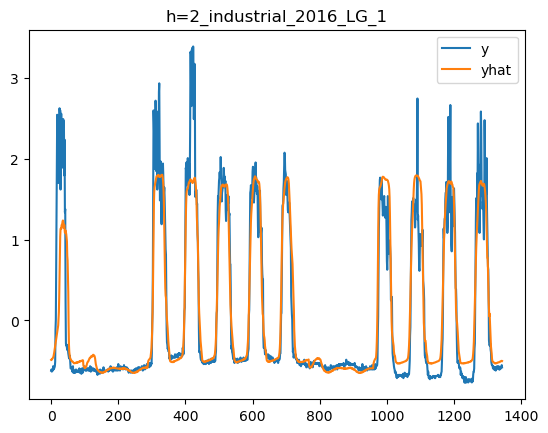

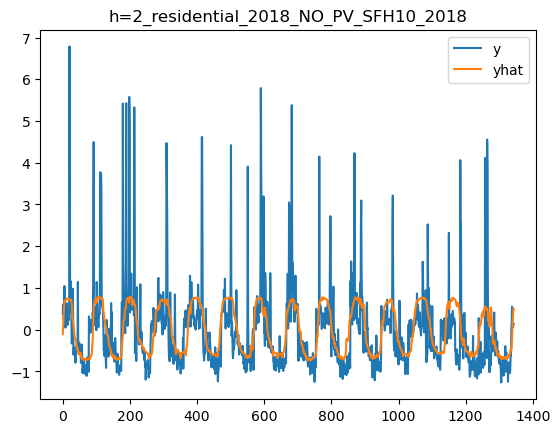

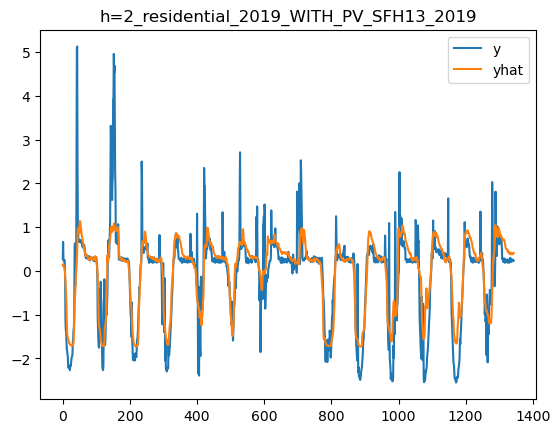

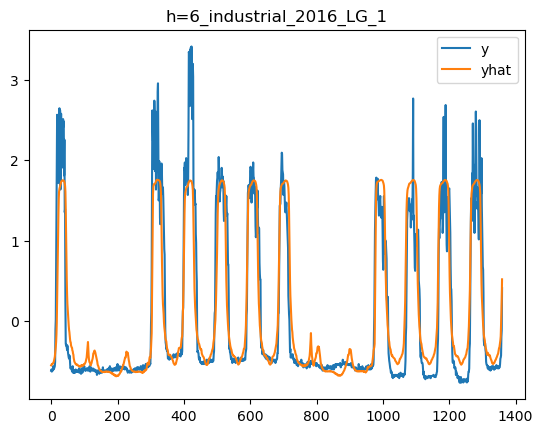

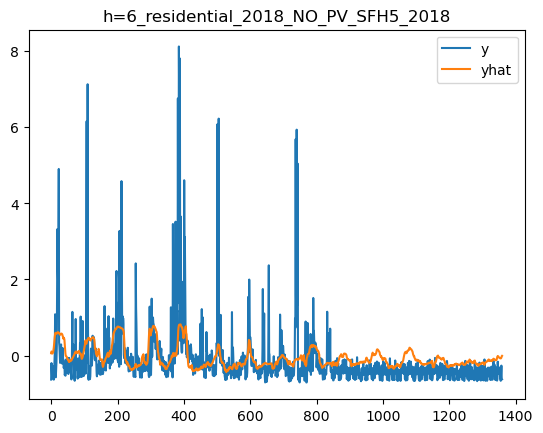

In [15]:
for i, row in df.iterrows():
    x = row["x"]
    x_ints = list(range(len(x)))

    y = row["y"]
    yhat = row["yhat"]
    fn = row["filename"]

    plt.plot(y, label="y")
    plt.plot(yhat, label="yhat")
    plt.legend()
    plt.title(fn)
    plt.show()

In [8]:
x[0]

'2016-01-15 00:15:00'